In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
import time
import sklearn
from collections import defaultdict
from sklearn import linear_model
from implicit import bpr
from surprise import SVD, Reader, Dataset
from sklearn.model_selection import train_test_split
import scipy.sparse as sp
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from surprise.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from datetime import datetime
import random
import dateutil.parser
from sklearn.preprocessing import MinMaxScaler
import string
from xgboost import XGBRegressor
from collections import Counter
from sklearn.metrics import mean_squared_error
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.linear_model import Ridge
from nltk.stem.porter import *

In [30]:
def parseData(fname):
    for l in open(fname):
        yield json.loads(l)

In [31]:
data = list(parseData("review-Vermont.json"))

In [32]:
metadata = list(parseData("meta-Vermont.json"))

# EDA

In [33]:
df = pd.DataFrame(data)
metadata_df = pd.DataFrame(metadata)

In [34]:
df.head()

,user_id,name,time,rating,text,pics,resp,gmap_id
0,104490523034805396984,Tia McCarthy,1629987079369,5.0,The Royal Group recently performed standard te...,None,"{'time': 1629988531658, 'text': 'Tia, You rock...",0x89e02445cb9db457:0x37f42bff4edf7a43
1,112062684820633635547,Rochelle Weitzner,1626442303453,5.0,I can't say enough great things about The Roya...,None,"{'time': 1626444234168, 'text': 'Morning Roche...",0x89e02445cb9db457:0x37f42bff4edf7a43
2,110048311042721875910,Baxter Holland,1627319568225,5.0,The Royal Group has done work for us over many...,None,"{'time': 1627319913364, 'text': 'Baxter, I tr...",0x89e02445cb9db457:0x37f42bff4edf7a43
3,106174372090234957142,Jack Droppa,1625223629975,5.0,The Royal Group was fantastic to work with. I ...,None,"{'time': 1625224706775, 'text': 'Morning Jack,...",0x89e02445cb9db457:0x37f42bff4edf7a43
4,106238734329148428463,Ty Danco,1630520930973,5.0,"Have used in different houses, installing mult...",None,"{'time': 1630521923452, 'text': 'Thanks so muc...",0x89e02445cb9db457:0x37f42bff4edf7a43


In [35]:
metadata_df.head()

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
0,Royal Group,"Royal Group, 150 Woodstock Ave, Rutland, VT 05701",0x89e02445cb9db457:0x37f42bff4edf7a43,None,43.615537,-72.960497,"[Security system supplier, Fire protection equ...",4.9,148,None,"[[Thursday, 8AM–5PM], [Friday, 8AM–5PM], [Satu...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 8AM,"[0x89e0245c4c5c7d2d:0x97bca40a0223d767, 0x89e0...",https://www.google.com/maps/place//data=!4m2!3...
1,Foxglove Farm and Forest,"Foxglove Farm and Forest, 777 Delorm Rd, Leice...",0x4cb549e8877cf0d7:0xe8f003e6d73392ae,None,43.855743,-73.088180,"[Indoor lodging, Farm, Gift shop]",5.0,3,None,None,None,None,None,https://www.google.com/maps/place//data=!4m2!3...
2,Carr's Gifts,"Carr's Gifts, 21 Center St, Brandon, VT 05733",0x4cb54a301f3518f7:0x39af4eda1efb9117,None,43.799002,-73.088269,[Gift shop],4.9,13,None,"[[Wednesday, 10AM–5PM], [Thursday, 10AM–5PM], ...","{'Service options': ['In-store shopping', 'Del...",Closed ⋅ Opens 10AM Thu,"[0x4cb54b57c4f3123b:0x3d4e844c93c72568, 0x4cb5...",https://www.google.com/maps/place//data=!4m2!3...
3,Midas,"Midas, 207 US Route 4 E, Woodstock Ave, Rutlan...",0x89e024446398691f:0x4011d3a0f8636036,None,43.623157,-72.953303,"[Auto repair shop, Brake shop, Muffler shop, O...",4.3,48,None,"[[Wednesday, 7:30AM–5PM], [Thursday, 7:30AM–5P...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 7:30AM Thu,"[0x89e02489914d34f9:0x31610a8d324af00d, 0x89e0...",https://www.google.com/maps/place//data=!4m2!3...
4,Keyser Energy,"Keyser Energy, 77 Grove St Suite G102, Rutland...",0x89e0247d160d7263:0x32e4f01896e33f3b,None,43.611359,-72.981580,"[Heating oil supplier, Air conditioning contra...",4.7,68,None,"[[Wednesday, 8AM–4:30PM], [Thursday, 8AM–4:30P...",None,Closed ⋅ Opens 8AM Thu,"[0x89e0248f040ed50d:0x20f29a9817069602, 0x89e0...",https://www.google.com/maps/place//data=!4m2!3...


In [36]:
nulls_per_column = metadata_df.isnull().sum()
print("Null values per column:")
print(nulls_per_column)

Null values per column:
name                   0
address               78
gmap_id                0
description         9651
latitude               0
longitude              0
category              41
avg_rating             0
num_of_reviews         0
price               9567
hours               3358
MISC                2623
state               3725
relative_results    1054
url                    0
dtype: int64


In [37]:
df = df.drop(columns = ['pics', 'resp'])
metadata_df = metadata_df.drop(columns=['address', 'category', 'MISC', 'state', 'relative_results', 'url'])
df.shape

(852203, 6)

In [38]:
nulls_per_column = df.isnull().sum()
print("Null values per column:")
print(nulls_per_column)

Null values per column:
user_id     10293
name            0
time            0
rating      10293
text       345133
gmap_id         0
dtype: int64


In [39]:
# Drop reviews without rating and text
df = df.dropna(subset=['rating', 'text'])
data = [record for record in data if record.get('rating') is not None]
data = [record for record in data if record.get('text') is not None]
df.shape

(496777, 6)

In [40]:
df['user_id'].value_counts().describe()

count    203213.000000
mean          2.444612
std           5.501693
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         296.000000
Name: count, dtype: float64

In [41]:
user_review_count = Counter([entry['user_id'] for entry in data])

thresholds = [1, 3, 5, 10]

for t in thresholds:
    # Find users with reviews below the threshold
    dropped_users = {user: count for user, count in user_review_count.items() if count < t}
    # Calculate total reviews dropped
    reviews_dropped = sum(dropped_users.values())
    print(f"Threshold: {t}, Users Dropped: {len(dropped_users)}, Reviews Dropped: {reviews_dropped}")

Threshold: 1, Users Dropped: 0, Reviews Dropped: 0
Threshold: 3, Users Dropped: 165913, Reviews Dropped: 195466
Threshold: 5, Users Dropped: 184486, Reviews Dropped: 257816
Threshold: 10, Users Dropped: 195773, Reviews Dropped: 329924


In [42]:
min_reviews = 3
data = [entry for entry in data if user_review_count[entry['user_id']] >= min_reviews]
df = pd.DataFrame(data)

Users with only one review will be hard to predict ratings for as collaborative filtering examines similarities between user preferences. 

In [43]:
df.shape

(301311, 8)

In [44]:
df['user_id'].value_counts().describe()

count    37300.000000
mean         8.078043
std         11.197622
min          3.000000
25%          3.000000
50%          5.000000
75%          8.000000
max        296.000000
Name: count, dtype: float64

In [45]:
df['datetime'] = pd.to_datetime(df['time'], unit='ms') 
df['month'] = df['datetime'].dt.month 
df['hour'] = df['datetime'].dt.hour

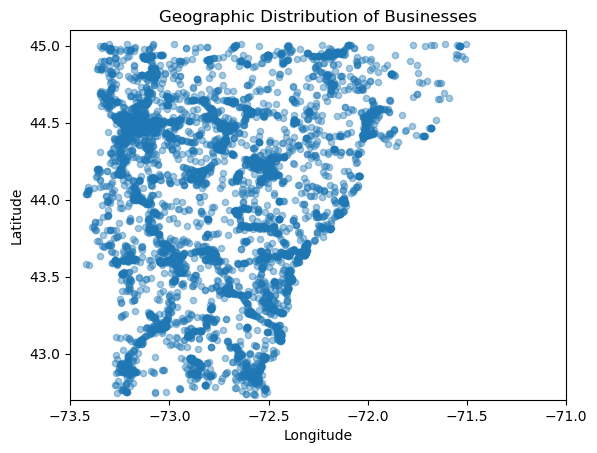

In [28]:
metadata_df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4)
plt.title("Geographic Distribution of Businesses")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-73.5, -71.0)  # Vermont longitude range
plt.ylim(42.7, 45.1) 
plt.show()

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

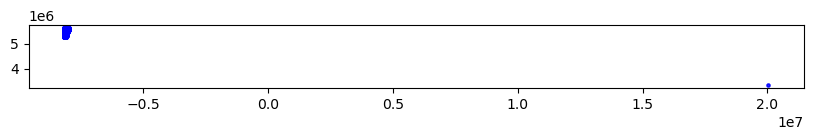

In [29]:
import contextily as ctx
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(metadata_df['longitude'], metadata_df['latitude'])]
geo_metadata_vermont = gpd.GeoDataFrame(metadata_df, geometry=geometry)

# Set the Coordinate Reference System (CRS) to WGS84 (latitude and longitude)
geo_metadata_vermont.crs = "EPSG:4326"

# Convert GeoDataFrame to Web Mercator for basemap compatibility
geo_metadata_vermont = geo_metadata_vermont.to_crs(epsg=3857)

# Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
geo_metadata_vermont.plot(ax=ax, color='blue', alpha=0.6, markersize=5)

# Add basemap
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    zoom=10
)

# Set plot title and labels
plt.title("Geographic Distribution of Businesses in Vermont")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.tight_layout()
plt.show()

In [21]:
# Look into reccomending by location

In [ ]:
df['datetime'] = pd.to_datetime(df['time'], unit='ms')  # Convert UNIX time to datetime
df['month'] = df['datetime'].dt.month  # Extract month

# Group by month and calculate average rating
seasonal_trends = df.groupby('month')['rating'].mean()

# Plot seasonal trends
plt.figure(figsize=(8, 5))
plt.plot(seasonal_trends.index, seasonal_trends.values, marker='o')
plt.xticks(ticks=range(1, 13), labels=['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.title("Seasonal Trends")
plt.xlabel("Time of year")
plt.ylabel("Average rating")
plt.grid(True)
plt.show()

In [ ]:
df['hour'] = df['datetime'].dt.hour

# Group by hour and calculate average rating
short_term_trends = df.groupby('hour')['rating'].mean()

# Plot short-term trends
plt.figure(figsize=(8, 5))
plt.plot(short_term_trends.index, short_term_trends.values, marker='o')
plt.xticks(ticks=range(0, 24, 2), labels=[f"{h}:00" for h in range(0, 24, 2)])
plt.title("Short-Term Trends")
plt.xlabel("Time of day")
plt.ylabel("Average rating")
plt.grid(True)
plt.show()

In [71]:
reviews_with_meta = pd.merge(df, metadata_df, on='gmap_id')

# Models

### Baseline

In [46]:
# convert metadata to dict to more easily look up metadata later
metadata_dict = {
    d['gmap_id']: {
        'latitude': d.get('latitude', 0),
        'longitude': d.get('longitude', 0),
        'avg_rating': d.get('avg_rating', 0),
        'num_of_reviews': d.get('num_of_reviews', 0)
    }
    for d in metadata
}

In [47]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [48]:
trainset, testset = train_test_split(data, test_size=.25, random_state=48)

In [49]:
ratings = [r['rating'] for r in data]
globalAverage = sum(ratings) * 1.0 / len(ratings)

In [50]:
validMSE = 0
for d in testset:
    sse = (d['rating'] - globalAverage)**2
    validMSE += sse

validMSE /= len(testset)

print("Baseline MSE on test set (predictions using global average) = " + str(validMSE))

Baseline MSE on test set (predictions using global average) = 1.1374923333241382


In [51]:
validMSE = 0
for d in testset:
    sse = (d['rating'] - metadata_dict[d['gmap_id']]['avg_rating'])**2
    validMSE += sse

validMSE /= len(testset)

print("Baseline MSE on test set (predictions using business average) = " + str(validMSE))

Baseline MSE on test set (predictions using business average) = 0.9711025116822765


### Note for later
- too lazy to do a collaboritive filtering model from similarties alone like we did in class right now, but should do later to show improvement

### SVD

In [28]:
trainset_df = pd.DataFrame(trainset)
testset_df = pd.DataFrame(testset)

In [29]:
model2 = SVD()

In [30]:
reader = Reader(rating_scale=(1, 5))
svdDataTrain = Dataset.load_from_df(trainset_df[['user_id', 'gmap_id', 'rating']], reader).build_full_trainset()
svdDataTest = list(testset_df[['user_id', 'gmap_id', 'rating']].itertuples(index=False, name=None))

In [31]:
model2.fit(svdDataTrain)
predictions = model2.test(svdDataTest)

In [32]:
labels = [d["rating"] for d in testset]
predictions = [d.est for d in predictions]

In [33]:
mse = MSE(predictions, labels)
print("SVD model without hyperparamter turning = " + str(mse))

SVD model without hyperparamter turning = 0.9045070407117858


In [136]:
from surprise.model_selection import GridSearchCV
data_for_gs = Dataset.load_from_df(pd.DataFrame(data)[['user_id', 'gmap_id', 'rating']], reader)
param_grid = {
    'n_factors': [50, 100],
    'n_epochs': [10, 20],  
    'lr_all': [0.002, 0.005], 
    'reg_all': [0.02, 0.05]      
}

grid_search = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=2)

grid_search.fit(data_for_gs)

print("Best RMSE Score:", grid_search.best_score['rmse'])
print("Best Parameters:", grid_search.best_params['rmse'])

Best RMSE Score: 0.9677866336534827
Best Parameters: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.05}


In [34]:
# from gridsearch Best RMSE Score: 0.9677866336534827
# Best Parameters: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.05}
# best_params = grid_search.best_params['rmse']
model3 = SVD(n_factors= 50, n_epochs= 20, lr_all= 0.005, reg_all= 0.05)

model3.fit(svdDataTrain)
predictions = model3.test(svdDataTest)

In [35]:
labels = [d["rating"] for d in testset]
predictions = [d.est for d in predictions]

In [36]:
mse_svd_tuned = MSE(predictions, labels)
print("SVD model with hyperparamter turning = " + str(mse_svd_tuned))

SVD model with hyperparamter turning = 0.895954756292148


### WordVec

In [22]:
merged_df = reviews_with_meta

# Prepare Features
# One-hot encode user_id and gmap_id
encoder = OneHotEncoder()
user_item_matrix = encoder.fit_transform(merged_df[['user_id', 'gmap_id']])

# Scale geographic and temporal features
scaler = StandardScaler()
geographic_features = scaler.fit_transform(merged_df[['latitude', 'longitude']])
temporal_features = pd.get_dummies(merged_df[['month', 'hour']])

# Generate Word2Vec Embeddings for Text
merged_df['processed_text'] = merged_df['text'].fillna('').str.split()  # Tokenize text
word2vec_model = Word2Vec(sentences=merged_df['processed_text'], vector_size=50, min_count=1, window=5, sg=1)

In [23]:
def compute_text_embedding(text_tokens):
    if not text_tokens:  # Handle empty text
        return np.zeros(word2vec_model.vector_size)
    embeddings = [word2vec_model.wv[token] for token in text_tokens if token in word2vec_model.wv]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(word2vec_model.vector_size)

In [34]:
text_features = np.array([compute_text_embedding(tokens) for tokens in merged_df['processed_text']])

# Combine all features into a single sparse matrix
feature_matrix = hstack([user_item_matrix, geographic_features, temporal_features, text_features])

# Target variable
target = merged_df['rating']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, target, test_size=0.25, random_state=42)

# Ridge Regression with GridSearchCV for Hyperparameter Tuning
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'fit_intercept': [True, False]     # Whether to include an intercept
}

ridge = Ridge()
grid_search = GridSearchCV(ridge, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate the model on the test set
best_ridge = grid_search.best_estimator_
y_pred = best_ridge.predict(X_test)

# Calculate evaluation metrics
mse_ridge = MSE(y_pred, y_test)

print(f"Best Ridge Regression MSE: {mse_ridge}")

Best parameters: {'alpha': 10.0, 'fit_intercept': True}


NameError: name 'MSE' is not defined

### Temporal

In [52]:
ratingsTime = []
for d in data:
    ratingsTime.append((d["time"], d["rating"]))

In [53]:
ratingsTime.sort()
len(ratingsTime)

301311

In [54]:
wSize = 1000
x = [r[0] for r in ratingsTime] # as raw times
y = [r[1] for r in ratingsTime] # ratings
x_datetime = [datetime.fromtimestamp(t / 1000) for t in x]
xu = [time.mktime(d.timetuple()) for d in x_datetime]

In [55]:
xSum = sum(xu[:wSize])
ySum = sum(y[:wSize])
sliding = []

In [56]:
for i in range(wSize,len(x)-1):
    xSum += xu[i] - xu[i-wSize]
    ySum += y[i] - y[i-wSize]
    sliding.append((xSum*1.0/wSize,ySum*1.0/wSize))

In [57]:
X = [a[0] for a in sliding]
Y = [a[1] for a in sliding]

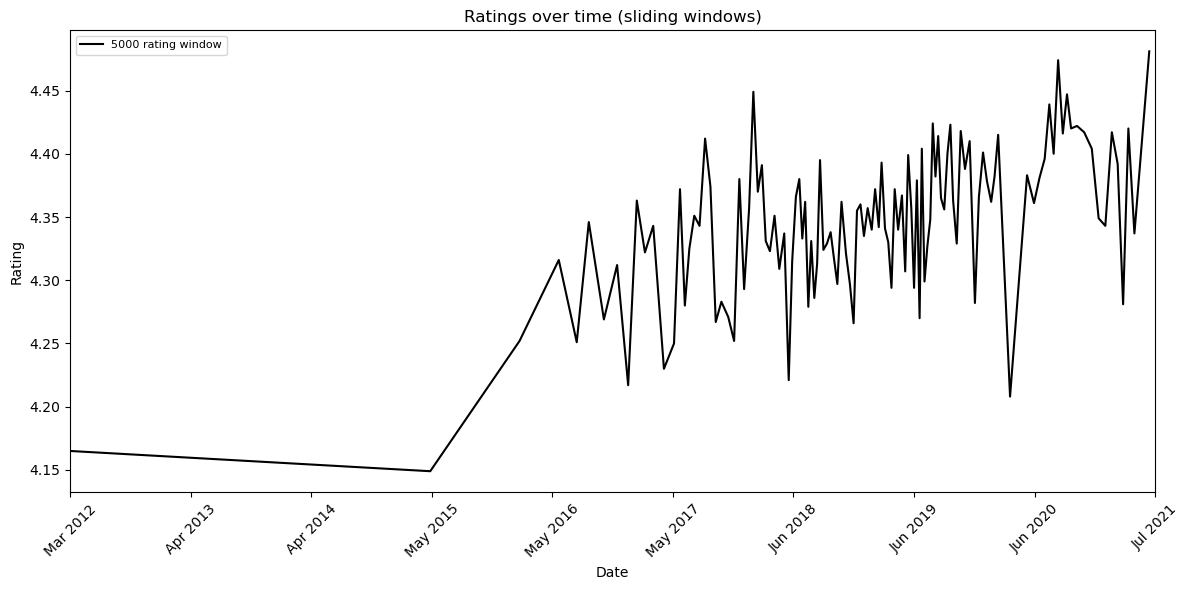

In [58]:
from datetime import datetime

# Define the start and end dates for the x-axis
start_date = datetime.fromtimestamp(X[0])  # Convert the first timestamp to datetime
end_date = datetime.fromtimestamp(X[-1])  # Convert the last timestamp to datetime

# Generate tick locations and labels
num_ticks = 10  # Number of ticks on the x-axis
tick_dates = [start_date + (end_date - start_date) * i / (num_ticks - 1) for i in range(num_ticks)]
tick_locations = [d.timestamp() for d in tick_dates]  # Convert datetime to UNIX timestamps
tick_labels = [d.strftime("%b %Y") for d in tick_dates]  # Format dates as "Month Year"

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(X[::2500], Y[::2500], label="5000 rating window", color='k')

# Add custom ticks and labels for the x-axis
plt.xticks(tick_locations, tick_labels, rotation=45)  # Rotate labels for better readability

# Add axis limits and labels
plt.xlim(X[0], X[-1])
plt.ylabel("Rating")
plt.xlabel("Date")
plt.legend(loc="best", fontsize=8)
plt.title("Ratings over time (sliding windows)")

# Adjust layout
plt.tight_layout()
plt.show()

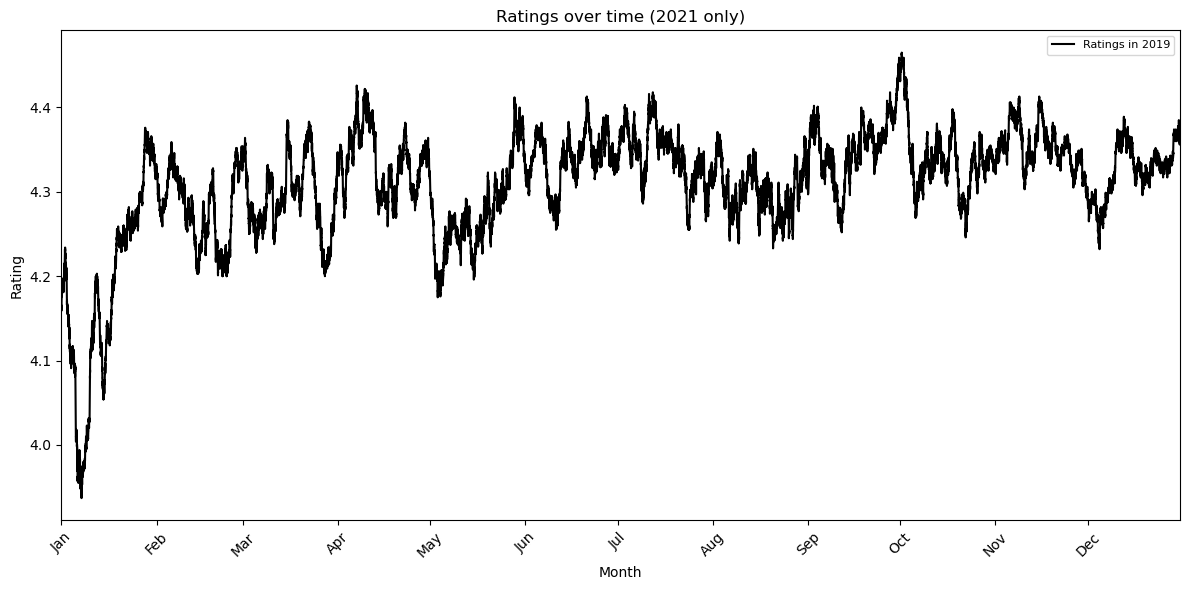

In [60]:
from datetime import datetime

# Define the specific year to show (e.g., 2021)
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 12, 31)

# Filter X and Y to only include data within the specified year
X_filtered = [x for x in X if start_date.timestamp() <= x <= end_date.timestamp()]
Y_filtered = Y[:len(X_filtered)]  # Adjust Y to match the filtered X

# Generate tick locations and labels for each month of the year
tick_dates = [datetime(2019, month, 1) for month in range(1, 13)]  # Start of each month
tick_locations = [d.timestamp() for d in tick_dates]  # Convert datetime to UNIX timestamps
tick_labels = [d.strftime("%b") for d in tick_dates]  # Format as "Jan", "Feb", etc.

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(X_filtered, Y_filtered, label="Ratings in 2019", color='k')

# Add custom ticks and labels for the x-axis
plt.xticks(tick_locations, tick_labels, rotation=45)  # Rotate labels for better readability

# Add axis limits and labels
plt.xlim(start_date.timestamp(), end_date.timestamp())
plt.ylabel("Rating")
plt.xlabel("Month")
plt.legend(loc="best", fontsize=8)
plt.title("Ratings over time (2021 only)")

# Adjust layout
plt.tight_layout()
plt.show()

Cool to notice drop off in ratings over covid

### unsure what im doing

In [45]:
userIDs,itemIDs = {},{}

for d in data:
    u,i = d['user_id'],d['gmap_id']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)

nUsers,nItems = len(userIDs),len(itemIDs)

In [46]:
nUsers,nItems

(37300, 10692)

In [47]:
userIDs = {}
itemIDs = {}
interactions = []
interactionsPerUser = defaultdict(list)

for d in data:
    u = d['user_id']
    i = d['gmap_id']
    t = d['time']
    r = d['rating']
    if not u in userIDs: userIDs[u] = len(userIDs)
    if not i in itemIDs: itemIDs[i] = len(itemIDs)
    interactions.append((t,u,i,r))

In [48]:
interactions.sort()

In [49]:
interactionsPerItem = defaultdict(list)
interactionsPerUser = defaultdict(list)
for t,u,i,r in interactions:
    interactionsPerItem[i].append((t,u,r))
    interactionsPerItem[i].append((t,i,r))

In [50]:
random.shuffle(interactions)

In [51]:
def feat(t,u,i):
    older = [r for (q,u,r) in interactionsPerItem[i] if q < t] # Collect previous ratings
    f = []
    for k in range(1,6):
        try:
            f += [0,older[-k]] # Previous rating
        except Exception as e:
            f += [1,0] # Or missing value indicator if we don't have history of length k
    if len(older):
        f += [0,sum(older)/len(older)] # Add feature for the average (going beyond just last k)
    else:
        f += [1,0] # Missing value indicator if no interaction history
    return f + [1]

In [52]:
X = [feat(t,u,i) for t,u,i,_ in interactions]
y = [r for _,_,_,r in interactions]

In [53]:
XF = sp.lil_matrix((len(interactions), nUsers + len(X[0])))

In [54]:
for n in range(len(interactions)):
    _,u,i,r = interactions[n]
    user = userIDs[u]
    XF[n,user] = 1
    for j in range(len(X[n])): # Copy features from previous model
        XF[n,nUsers+j] = X[n][j]

In [55]:
fm = als.FMRegression(n_iter=100, rank=2, l2_reg_w=0.1, l2_reg_V=0.5)

In [56]:
y = np.array(y)
Xtrain, Xtest, ytrain, ytest = train_test_split(XF, y, test_size=0.2, random_state=48)

In [61]:
fm.fit(Xtrain, ytrain)

FMRegression(l2_reg_V=0.5, rank=2)

In [63]:
y_pred = fm.predict(Xtest)

In [65]:
MSE(y_pred, ytest)

1.2485398047630922

In [24]:
punctuation = set(string.punctuation)
def feature(datum, words, wordId, tolower=True, removePunct=True):
    feat = [0]*len(words)
    r = datum['text']
    if tolower:
        r = r.lower()
    if removePunct:
        r = ''.join([c for c in r if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

In [25]:
def process_text(dSize = 1000, tolower=True, removePunct=True):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in trainset: # Strictly, should just use the *training* data to extract word counts
        r = d['text']
        if tolower:
            r = r.lower()
        if removePunct:
            r = ''.join([c for c in r if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1

    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()
    
    words = [x[1] for x in counts[:dSize]]
    
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)
    
    return words, wordId, tolower, removePunct

In [26]:
words, wordId, tolower, removePunct = process_text(1500, True, True)

In [69]:
X = [feature(d, words, wordId, tolower, removePunct) for d in trainset]
y = [d['rating'] for d in trainset]

Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.2, random_state=48)


bestModel = None
bestVal = None
bestLamb = None

ls = [0.01, 0.1, 1]
errorTrain = []
errorValid = []

for l in ls:
    model = sklearn.linear_model.Ridge(l)
    model.fit(Xtrain, ytrain)
    predictTrain = model.predict(Xtrain)
    MSEtrain = sum((ytrain - predictTrain)**2)/len(ytrain)
    errorTrain.append(MSEtrain)
    predictValid = model.predict(Xvalid)
    MSEvalid = sum((yvalid - predictValid)**2)/len(yvalid)
    errorValid.append(MSEvalid)
    print("l = " + str(l) + ", validation MSE = " + str(MSEvalid))
    if bestVal == None or MSEvalid < bestVal:
        bestVal = MSEvalid
        bestModel = model
        bestLamb = l
    
bestModel.fit(Xtrain, ytrain)
    
coefficients = bestModel.coef_
words_with_coefficients = [(word, coef) for word, coef in zip(words, coefficients)]

sorted_words = sorted(words_with_coefficients, key=lambda x: x[1], reverse=True)


Xtest = [feature(d, words, wordId, tolower, removePunct) for d in testset]
ytest = [d['rating'] for d in testset]

predictTest = bestModel.predict(Xtest)
MSEtest = MSE(predictTest, ytest)
print("MSE on test set = " + str(MSEtest))

l = 0.01, validation MSE = 0.6920460082789037
l = 0.1, validation MSE = 0.6920434232819487
l = 1, validation MSE = 0.6920178664588031
MSE on test set = 0.6859117152489979


/var/folders/nr/sn_d7m6s0zq4vml99kcs24kh0000gn/T/ipykernel_34826/2851932295.py:21: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  plt.tight_layout()
/Users/calebgaldston/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128077 (\N{THUMBS UP SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


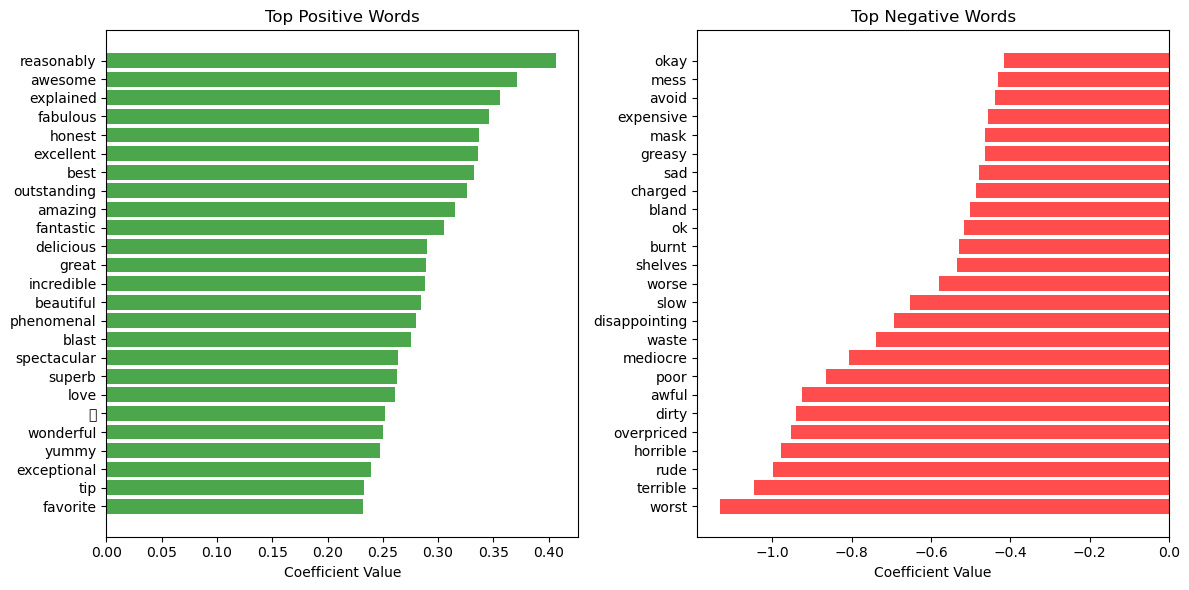

In [70]:
most_positive = sorted_words[:25] 
most_negative = sorted_words[-25:]
positive_words, positive_coefs = zip(*most_positive)
negative_words, negative_coefs = zip(*most_negative)

# Create a bar chart
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Positive coefficients
ax[0].barh(positive_words, positive_coefs, color='green', alpha=0.7)
ax[0].set_title("Top Positive Words")
ax[0].set_xlabel("Coefficient Value")
ax[0].invert_yaxis()  # Highest value on top

# Negative coefficients
ax[1].barh(negative_words, negative_coefs, color='red', alpha=0.7)
ax[1].set_title("Top Negative Words")
ax[1].set_xlabel("Coefficient Value")
ax[1].invert_yaxis()  # Lowest value on top

plt.tight_layout()
plt.show()

In [133]:
user_ids = list({d['user_id'] for d in trainset})
item_ids = list({d['gmap_id'] for d in trainset})  # Assuming 'gmap_id' is the item identifier

# Create mappings from user_id and item_id to their indices
user_id_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
item_id_to_index = {item_id: idx for idx, item_id in enumerate(item_ids)}
user_factors = {user_id: model3.pu[user_id_to_index[user_id]] for user_id in user_id_to_index}
item_factors = {item_id: model3.qi[item_id_to_index[item_id]] for item_id in item_id_to_index}

In [27]:
def extract_features(d):
    # Content-based features (e.g., from review text)
    content_features = feature(d, words, wordId, tolower, removePunct)

    metadata = metadata_dict.get(d['gmap_id'])
    # Metadata features
    metadata_features = [
        metadata['latitude'],
        metadata['longitude'],
        metadata['avg_rating'],
        metadata['num_of_reviews']
    ]

    # Time feature
    def extract_time_features(timestamp):
        dt = datetime.fromtimestamp(timestamp / 1000)  # Convert from milliseconds
        return [dt.year, dt.month, dt.day, dt.hour]

    time_features = extract_time_features(d.get('time', 0))

    return np.concatenate([content_features, metadata_features, time_features])

In [28]:
from sklearn.model_selection import GridSearchCV
X = [extract_features(d) for d in trainset]
y = [d['rating'] for d in trainset]

Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.2, random_state=48)

param_grid = {
    'n_estimators': [100],  # Number of trees
    'learning_rate': [0.2],  # Learning rate
    'max_depth': [5]
}

xgb_model = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    cv=2,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all CPU cores
)
    
grid_search.fit(Xtrain, ytrain)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Negative MSE to positive MSE
print("Best Parameters:", best_params)
print("Best CV Score (MSE):", best_score)

# Evaluate the model on the validation set using the best parameters
best_model = grid_search.best_estimator_
    
predictValid = best_model.predict(Xvalid)
mseValid = MSE(predictValid, yvalid)
print("MSE validation = " + str(mseValid))

Xtest = [extract_features(d) for d in testset]
ytest = [d['rating'] for d in testset]

predictTest = best_model.predict(Xtest)
MSEtest = MSE(predictTest, ytest)
print("MSE on test set = " + str(MSEtest))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best CV Score (MSE): 0.5862425853417095
MSE validation = 0.5852958113296175
MSE on test set = 0.5737450323920966
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=  54.7s
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=  47.5s


Note:
- xgboost performs better than ridge in this case (ridge MSE: MSE on test set = 0.6349580790594409


In [87]:
def extract_features2(d):
    metadata = metadata_dict.get(d['gmap_id'])
    # Metadata features
    metadata_features = [
        metadata['latitude'],
        metadata['longitude'],
        metadata['avg_rating'],
        metadata['num_of_reviews']
    ]
    user_latent = user_factors.get(d['user_id'], [0] * len(next(iter(user_factors.values()))))

    # Latent factors for item
    item_latent = item_factors.get(d['gmap_id'], [0] * len(next(iter(item_factors.values()))))

    # Time feature
    def extract_time_features(timestamp):
        dt = datetime.fromtimestamp(timestamp / 1000)  # Convert from milliseconds
        return [dt.year, dt.month, dt.day, dt.hour]

    time_features = extract_time_features(d.get('time', 0))

    return np.concatenate([content_features, metadata_features, time_features, user_latent, item_latent])

In [171]:
from sklearn.model_selection import GridSearchCV
X = [extract_features2(d) for d in trainset]
y = [d['rating'] for d in trainset]

Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.2, random_state=48)

param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
}

xgb_model1 = XGBRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model1,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Use MSE as the scoring metric
    cv=2,  # 2-fold cross-validation
    verbose=1,  # Enable progress updates
    n_jobs=-1  # Use all available CPU cores
)

grid_search.fit(X, y)

# Retrieve the best parameters and score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert negative MSE to positive
print("Best Parameters:", best_params)
print("Best CV MSE:", best_score)

# Train the final model with the best parameters
final_xgb_model1 = XGBRegressor(**best_params, random_state=42)
final_xgb_model1.fit(X, y)

Xtest = [extract_features2(d) for d in testset]
ytest = [d['rating'] for d in testset]

predictTest = final_xgb_model1.predict(Xtest)
MSEtest = MSE(predictTest, ytest)
print("MSE on test set = " + str(MSEtest))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}
Best CV MSE: 0.9643690359696405
MSE on test set = 0.9313815409444163


In [90]:
def extract_metadata_features(d):
    metadata = metadata_dict.get(d['gmap_id'])
    metadata_features = [
        metadata['latitude'],
        metadata['longitude'],
        metadata['avg_rating'],
        metadata['num_of_reviews']
    ]
    def extract_time_features(timestamp):
        dt = datetime.fromtimestamp(timestamp / 1000)  # Convert from milliseconds
        return [dt.year, dt.month, dt.day, dt.hour]

    time_features = extract_time_features(d.get('time', 0))

    return np.concatenate([metadata_features, time_features])

In [94]:
# best review independent model
scaler = StandardScaler()
X = [extract_metadata_features(d) for d in trainset]
X = scaler.fit_transform(X)
y = [d['rating'] for d in trainset]

Xtrain, Xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.2, random_state=48)

bestModel = None
bestVal = None
bestLamb = None

ls = [0.01, 0.1, 1]
errorTrain = []
errorValid = []

for l in ls:
    model = sklearn.linear_model.Ridge(l)
    model.fit(Xtrain, ytrain)
    predictTrain = model.predict(Xtrain)
    MSEtrain = sum((ytrain - predictTrain)**2)/len(ytrain)
    errorTrain.append(MSEtrain)
    predictValid = model.predict(Xvalid)
    MSEvalid = sum((yvalid - predictValid)**2)/len(yvalid)
    errorValid.append(MSEvalid)
    print("l = " + str(l) + ", validation MSE = " + str(MSEvalid))
    if bestVal == None or MSEvalid < bestVal:
        bestVal = MSEvalid
        bestModel = model
        bestLamb = l
        
Xtest = [extract_metadata_features(d) for d in testset]
Xtest = scaler.fit_transform(Xtest)
ytest = [d['rating'] for d in testset]
bestModel.fit(X, y)
metadata_pred = bestModel.predict(Xtest)

# svp predictions from earlier
svd_pred = [model3.predict(d['user_id'], d['gmap_id']).est for d in testset]

# Weighted hybrid predictions
alpha = 0.81  # Weight for CF predictions
hybrid_pred = [
    alpha * cf + (1 - alpha) * meta for cf, meta in zip(svd_pred, metadata_pred)
]

# ypred_array = np.array(ytest)
# hybrid_pred_array = np.array(hybrid_pred)
# Calculate validation MSE
MSEtest = MSE(hybrid_pred, ytest)
print("MSE Test (Hybrid):", MSEtest)

l = 0.01, validation MSE = 0.9994479620210427
l = 0.1, validation MSE = 0.9994479605425559
l = 1, validation MSE = 0.9994479457622055
MSE Test (Hybrid): 0.8907750064150773


In [95]:
def tune_alpha(cf_pred, metadata_pred, ytest):
    best_alpha = None
    best_mse = float('inf')
    alphas = np.linspace(0, 1, 101)  # Test alpha values from 0 to 1 in steps of 0.05

    for alpha in alphas:
        # Weighted hybrid predictions
        hybrid_pred = [
            alpha * cf + (1 - alpha) * meta for cf, meta in zip(cf_pred, metadata_pred)
        ]
        hybrid_pred_array = np.array(hybrid_pred)
        mse = np.mean((np.array(ytest) - hybrid_pred_array) ** 2)
        
        if mse < best_mse:
            best_mse = mse
            best_alpha = alpha

    return best_alpha, best_mse

In [96]:
tune_alpha(svd_pred, metadata_pred, ytest)

(0.81, 0.8907750064150776)

In [100]:
def recommend_businesses(user_id, n_recommendations=5):
    user_ratings = []
    
    for business_id in metadata_dict.keys():  # Iterate through all businesses
        # Check if user has already rated the business
        if any(d['user_id'] == user_id and d['gmap_id'] == business_id for d in data):
            continue  # Skip already-rated businesses
        
        # Metadata-based prediction
        metadata_features = extract_metadata_features({'gmap_id': business_id})
        metadata_features_scaled = scaler.transform([metadata_features])  # Scale metadata features
        metadata_rating = bestModel.predict(metadata_features_scaled)[0]
        
        # CF-based prediction
        cf_rating = model3.predict(user_id, business_id).est
        
        # Hybrid prediction
        hybrid_rating = alpha * cf_rating + (1 - alpha) * metadata_rating
        
        # Append the business and predicted rating
        user_ratings.append((business_id, hybrid_rating))
    
    # Sort by predicted rating and return top recommendations
    user_ratings = sorted(user_ratings, key=lambda x: x[1], reverse=True)
    return user_ratings[:n_recommendations]

In [102]:
recommend_businesses(110048311042721875910)

KeyboardInterrupt: 

[{'user_id': '110048311042721875910',
  'name': 'Baxter Holland',
  'time': 1627319568225,
  'rating': 5,
  'text': 'The Royal Group has done work for us over many years. The latest was installing new triple track storm windows. The quality of the work was excellent. Their technicians were courteous, professional and very efficient. It was a pleasure to have them in our house. I would have no hesitation to use The Royal Group again.',
  'pics': None,
  'resp': {'time': 1627319913364,
   'text': "Baxter,\n\nI truly appreciate your kind words and years of local business and support. Thanks so much for taking time to leave us a review! I'm so happy to hear that Dan and Kyle did a great job for you on this recent project.\n\nThank you again and have an excellent week\n\nRex Accavallo, CEO"},
  'gmap_id': '0x89e02445cb9db457:0x37f42bff4edf7a43'},
 {'user_id': '106238734329148428463',
  'name': 'Ty Danco',
  'time': 1630520930973,
  'rating': 5,
  'text': 'Have used in different houses, inst